## import related package

In [1]:
import os
import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pandas import DataFrame
from scipy.io import loadmat
from sklearn.mixture import GaussianMixture

## extract one Frame each time

In [2]:
def Slice_oneframe(Data):
    """
    frome the source data slice one frame
    """
    Rssi = Data[0,3]
    Data_frame = []
    j = 0
    for i in list(range(len(Data[:,0]))):
        if Data[i,3] == Rssi:
            if j == 200:
                Data_frame.append(Data[i,1:3])
        else:
            Rssi = Data[i,3]
            j = j+1
            if j>201:
                break
    return np.array(Data_frame)

## implementation for E-Step

In [3]:
def Estimation_step(X_Frame, Mu, Sigma, Pi, k_num):
    """
    """
    N, D = X_Frame.shape
    print(Sigma)
    psi = np.zeros([N,k_num])
    Gamma = np.zeros([N,k_num])
    for k in list(range(k_num)):
        Y = X_Frame - np.tile(Mu[k,:],(N,1))
        Det = np.linalg.det(Sigma[k,:,:])
        #for l in list(range(N)):
        Cov_inter = np.dot(np.dot(Y, np.linalg.inv(Sigma[k,:,:])), np.transpose(Y))
        for l in list(range(N)):
            psi[l,k] = ((2*math.pi)**(-D/2))*(Det**(-1/2))*math.exp(-1/2*Cov_inter[l,l])
        #DFAFA = ((2*math.pi)**(-D/2))*(Det**(-1/2))*np.diag(math.exp(-1/2*Cov_inter))
    #print(psi)
    
    for i in list(range(N)):
        for j in list(range(k_num)):
            Gamma[i,j] = Pi[0,j]*psi[i,j]/sum(np.dot(psi[i,:], np.transpose(Pi)))
    #print(Gamma)   
    return Gamma     

## implementation for M-Step

In [4]:
def Maximization_step(X_Frame, Gamma, k_num, Mu, Sigma, Pi,):
    """
    """
    N, D = X_Frame.shape
    for k in list(range(k_num)):
        # update Mu
        Mu_sum = np.zeros([1,D])
        for i in list(range(N)):
            Mu_sum = Mu_sum+Gamma[i,k]*X_Frame[i,:]
        Mu[k,:] = Mu_sum/sum(Gamma[:,k])
        # update Sigma
        Sigma_SUM = np.zeros([D,D])
        for j in list(range(N)):
            Sigma_SUM = Sigma_SUM + Gamma[j,k]*np.transpose(X_Frame[j,:]-Mu[k,:])*(X_Frame[j,:]-Mu[k,:])
        Sigma[k,:,:] = Sigma_SUM/sum(Gamma[:,k])
        # updata Pi
        Pi_SUM = 0
        for m in list(range(N)):
            Pi_SUM = Pi_SUM + Gamma[m,k]
        Pi[0,k] = Pi_SUM/N
    
    return Mu, Sigma, Pi
        
        

In [5]:
def gaussianMM(X, k_centnum):
    """
    """
    #psi = np.zeros([N,k_centnum])
    N, D = X.shape
    Mu = X[:4,:]
    Sigma = np.zeros([k_centnum,D,D])
    
    
    Pi = np.zeros([1,k_centnum])
    
    for s in list(range(k_centnum)):
        Pi[0,s] = 1/k_centnum
        Sigma[s,:,:] = np.cov(np.transpose(X))
    Lmu = Mu
    Lsigma = Sigma
    Lpi = Pi
    
    while (True):
        
        Gamma = Estimation_step(X, Mu, Sigma, Pi, k_centnum)
        # Estimation step
        Mu, Sigma, Pi = Maximization_step(X, Gamma, k_centnum, Mu, Sigma, Pi)
     
        # Maximization Step 
        R_Mu = sum(sum(abs(Lmu - Mu)))
        
        R_Sigma = sum(sum(sum(abs(Lsigma-Sigma))))
        
        R_Pi = sum(sum(abs(Lpi - Pi)))
        
        R = R_Mu+R_Sigma+R_Pi
        if (R<1e-10):
            print('Expect:')
            print(Mu)
            print('Covariance:')
            print(Sigma)
            print('Weight:')
            print(Pi)
            print(sum(sum(Pi)))
            break
        Lmu = Mu
        Lsigma = Sigma
        Lpi = Pi

In [6]:
def main():
    
    diroot = r"D:\Users\dell\AppData\Roaming\SPB_Data\RBFNN\Matlab_File"
    
    Data_r = loadmat(os.path.join(diroot,'direct02_16-09-07_0718_001.mat'))
    Datar = Data_r['x']
    
    Data_Frame = Slice_oneframe(Datar)
    
    gaussianMM(Data_Frame, 4)
    Dframe = pd.DataFrame(Data_Frame)
    #print(Data_Frame)
    fig = plt.figure(1) 
    #fig.suptitle('No axes on this figure')
    plt.scatter(Dframe[0],Dframe[1])
    
    #gmm = GaussianMixture(n_components=3)
    
    #gmm.fit(Dframe)
    
    #labels = gmm.predict(Dframe)
    #print(labels)
    
    #params = gmm.get_params()
    #print(params)
    
    #Dframe['labels']= labels
    #d0 = Dframe[Dframe['labels']== 0]
    #d1 = Dframe[Dframe['labels']== 1]
    #d2 = Dframe[Dframe['labels']== 2]
    #d3 = Dframe[Dframe['labels']== 3]
    
    
    #plt.scatter(d0[0],d0[1],c='r')
    #plt.scatter(d1[0],d1[1],c='yellow')
    #plt.scatter(d2[0],d2[1],c='g')
    #plt.scatter(d3[0],d3[1],c='b')
    

[[[1.97107794e-05 6.18326664e-07]
  [6.18326664e-07 1.93626775e-05]]

 [[1.97107794e-05 6.18326664e-07]
  [6.18326664e-07 1.93626775e-05]]

 [[1.97107794e-05 6.18326664e-07]
  [6.18326664e-07 1.93626775e-05]]

 [[1.97107794e-05 6.18326664e-07]
  [6.18326664e-07 1.93626775e-05]]]
Expect:
[[-0.00327684  0.00320766]
 [ 0.00331975 -0.00339181]
 [-0.00331926 -0.00342805]
 [ 0.00343321  0.00330784]]
Covariance:
[[[8.84810630e-06 8.71471798e-06]
  [8.84810630e-06 8.71471798e-06]]

 [[8.62187123e-06 7.98037611e-06]
  [8.62187123e-06 7.98037611e-06]]

 [[8.79836185e-06 7.83662577e-06]
  [8.79836185e-06 7.83662577e-06]]

 [[7.86824802e-06 8.28482260e-06]
  [7.86824802e-06 8.28482260e-06]]]
Weight:
[[0.2414077  0.25205221 0.25100621 0.25553389]]
1.0000000000000002


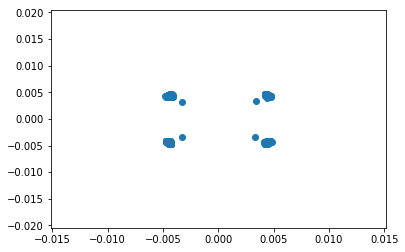

In [7]:
if __name__ =="__main__":

    main()

In [8]:
from numpy import *
xq = np.array([[2,3],[5,6]])
xxx = math.exp(xq[1,:])

TypeError: only size-1 arrays can be converted to Python scalars